In [1]:
import tensorflow.keras as keras
from tensorflow.keras import initializers,regularizers
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import math
import matplotlib.pylab as plt
import matplotlib
from random import random

In [2]:
import numpy as np
import pandas as pd

In [3]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [4]:
from scipy.optimize import curve_fit
def line_function(x,m,b):
    return m * x + b
def quadratic_function(x,m,b):
    y = b + m * x
    return y

In [5]:
def new_df(df,mass):
    df['mass'] = [mass for i in range(len(df))]
    df['log_energy'] = np.log10(df['energy'])
    df['cos_zenith'] = np.cos(df['zenith'])
    df['log_energy_loss'] = np.log10(df['energy_loss'])
    df['log_xo'] = np.log10(df['new_xo'])
    df['log_m_r'] = np.log10(df['m_r'])
    df['log_charge'] = np.log10(df['charge'])
    df['log_s_std'] = np.log10(df['s_std'])
    df['log_s_mean'] = np.log10(df['s_mean'])
    value = line_function(df['ghRedChiSqr'].values,-2e-3,1.)
    check = np.array([i<j for i,j in zip(value,df['m_chi2'].values)])
    df = df.loc[(df['Xmax']<900)&
                (df['Xmax']>400)&
                (np.isnan(df['log_charge'])==False)&
                (df['fit_status_m']!=0)&
                (df['S125']>0)&
                (df['m_r']>1e-8)&
                (df['m_r']<2e-4)&
                (abs(df['m_chi2'])<2)&
                (df['ghRedChiSqr']<500)&
                (abs(df['max_check'])<=15)&
               (abs(df['m_125'])>=0)&
               (df['m_s']>=0.4)&
               (df['m_s']<1)&
               (df['m_s2']>=0)&
               (df['m_s2']<50)&
               (df['m_o']<5)&
               (df['m_o']>3)]
    return df

In [6]:
def binning(x,y,bins,plot=False):
    check1 = list(zip(x,y))
    hist1 = np.histogram(x,bins=bins)
    mean = [[] for i in range(len(hist1[1][0:len(hist1[1])-1]))]
    mean_count = np.zeros(len(mean))
    index = range(len(mean))
    for i in check1:
        for j in index:
            if (i[0] > hist1[1][j] and i[0] < hist1[1][j+1]):
                mean[j].append( i[1])
                mean_count[j]+=1

    mean_overall = [np.mean(i) for i in mean]
    std_mean = [np.std(i) for i in mean]
    median = [np.median(i) for i in mean]
    
    bins = hist1[1][0:len(hist1[1])-1]
    if plot:
        for j in range(len(mean)):
            plt.hist(mean[j],bins=100)
            plt.xlabel('Xmax')
            plt.title('%f to %f'%(hist1[1][j],hist1[1][j+1]))
            plt.show()
    return mean_overall,std_mean,bins,median

In [7]:
iron = pd.read_csv('Iron.csv')
proton = pd.read_csv('Proton.csv')
helium = pd.read_csv('Helium.csv')
oxygen = pd.read_csv('Oxygen.csv')
proton2 = pd.read_csv('Proton2.csv')
iron2 =  pd.read_csv('Iron2.csv')
proton3 = pd.read_csv('Proton3.csv')
iron3 = pd.read_csv('Iron3.csv')
proton4 = pd.read_csv('Proton4.csv')
iron4 = pd.read_csv('Iron4.csv')

In [8]:
iron.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum'],
      dtype='object')

In [9]:
iron = new_df(iron,4)
proton = new_df(proton,1)
helium = new_df(helium,2)
oxygen = new_df(oxygen,3)
proton2 = new_df(proton2,1)
iron2 = new_df(iron2,4)
proton3 = new_df(proton3,1)
iron3 = new_df(iron3,4)
proton4 = new_df(proton4,1)
iron4 = new_df(iron4,4)

/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/andy/.local/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


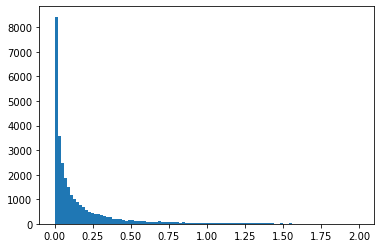

In [10]:
plt.hist(iron['m_chi2'].values,bins=100)
plt.show()

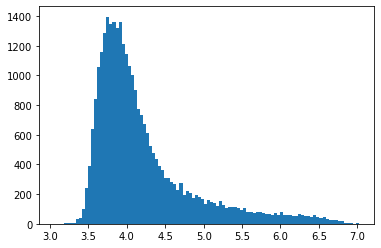

In [11]:
plt.hist(iron['m_125'].values,bins=100)
plt.show()

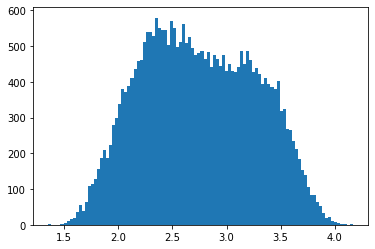

In [12]:
plt.hist(iron['log_charge'].values,bins=100)
plt.show()

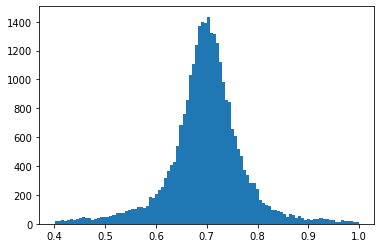

In [13]:
plt.hist(iron['m_s'][(iron['m_s'].values<1.5)&(iron['m_s'].values>0)],bins=100)
plt.show()

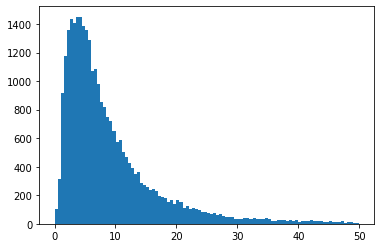

In [14]:
plt.hist(iron['m_s2'][(iron['m_s2'].values<50)&(iron['m_s2'].values>0)],bins=100)
plt.show()

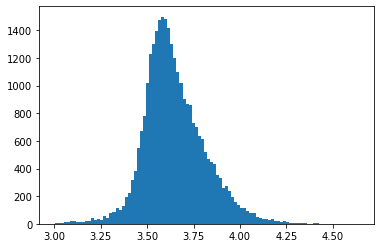

In [15]:
plt.hist(iron['m_o'][(iron['m_o'].values<5)&(iron['m_o'].values>0)],bins=100)
plt.show()

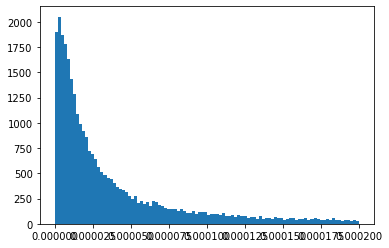

In [16]:
plt.hist(iron['m_r'][(iron['m_r'].values<2e-4)&(iron['m_r'].values>1e-8)],bins=100)
plt.show()

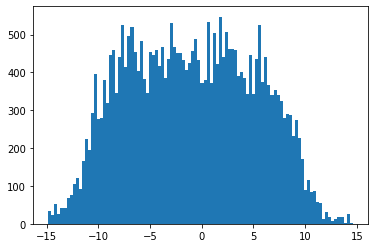

In [17]:
plt.hist(oxygen['max_check'].values,bins=100)
plt.show()

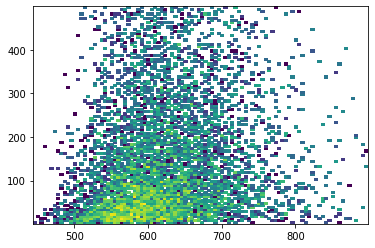

In [18]:
plt.hist2d(proton['Xmax'],proton['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

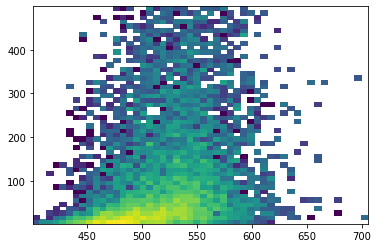

In [19]:
plt.hist2d(iron['Xmax'],iron['ghRedChiSqr'],bins=50,norm=matplotlib.colors.LogNorm())
plt.show()

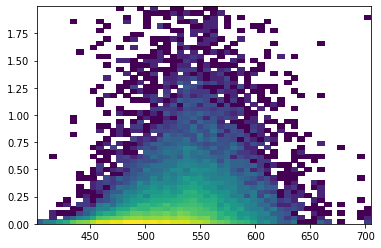

In [20]:
plt.hist2d(iron['Xmax'],iron['m_chi2'],bins=50,norm=matplotlib.colors.LogNorm())
plt.show()

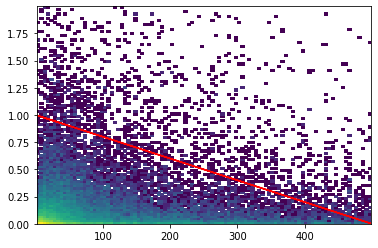

In [21]:
plt.hist2d(iron['ghRedChiSqr'],iron['m_chi2'],bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(iron['ghRedChiSqr'].values,line_function(iron['ghRedChiSqr'].values,-2e-3,1.),color='r')
plt.show()

In [22]:
from sklearn.cluster import KMeans
import seaborn

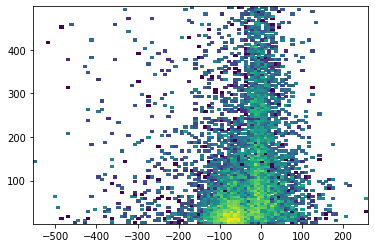

In [23]:
plt.hist2d(helium['Xo'],helium['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

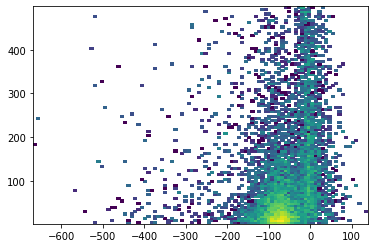

In [24]:
plt.hist2d(oxygen['Xo'],oxygen['ghRedChiSqr'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

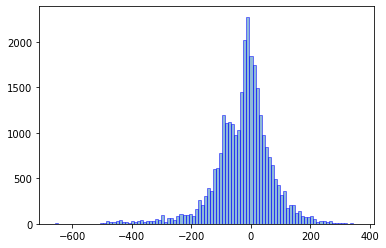

In [25]:
plt.hist(proton['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Proton_Xo.png')

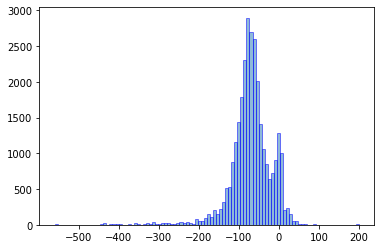

In [26]:
plt.hist(iron['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Iron_Xo.png')

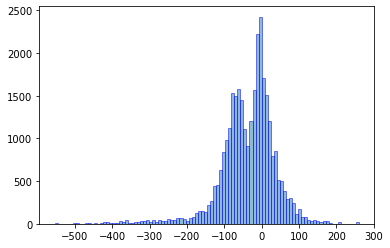

In [27]:
plt.hist(helium['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Helium_Xo.png')

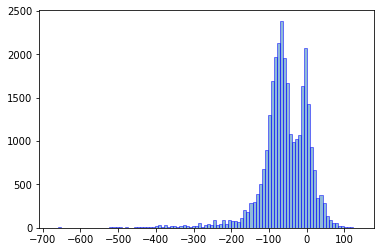

In [28]:
plt.hist(oxygen['Xo'],bins=100,alpha=0.5,facecolor=None,edgecolor='b')
plt.savefig('Oxygen_Xo.png')

In [29]:
df = iron.append(proton)
df = df.append(helium)
df = df.append(oxygen)
df = df.append(proton2)
df = df.append(iron2)
df = df.append(proton3)
df = df.append(iron3)
df = df.append(proton4)
df = df.append(iron4)

In [30]:
df.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum',
       'log_energy', 'cos_zenith', 'log_energy_loss', 'log_xo', 'log_m_r',
       'log_charge', 'log_s_std', 'log_s_mean'],
      dtype='object')

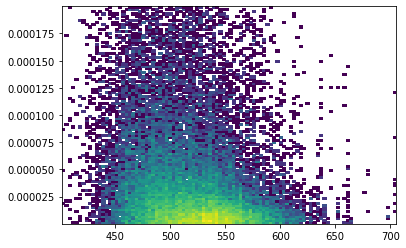

In [31]:
plt.hist2d(iron['Xmax'].values,iron['m_r'],bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

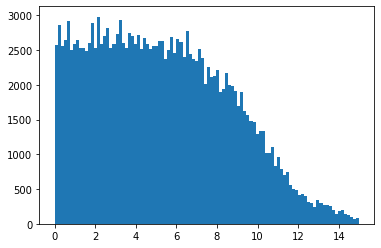

In [32]:
plt.hist(abs(df['max_check']),bins=100)
plt.show()

In [33]:
df['log_energy'] = df['log_energy'].values

In [34]:
df.head()

,Unnamed: 0,mass,energy,zenith,S125,energy_loss,he_stoch,he_stoch2,Xmax,Xo,...,difference,MaxNum,log_energy,cos_zenith,log_energy_loss,log_xo,log_m_r,log_charge,log_s_std,log_s_mean
5,5,4,10826061.0,0.510181,0.840283,NaN,NaN,NaN,477.023376,-70.472221,...,0.0,4520024.0,7.034470,0.872656,NaN,0.0,-4.762436,2.512044,-0.985788,-0.147946
7,7,4,10826061.0,0.500144,0.922709,NaN,NaN,NaN,477.023376,-70.472221,...,0.0,4520024.0,7.034470,0.877513,NaN,0.0,-4.316061,2.247012,-0.944173,-0.151576
15,15,4,15014645.0,0.715913,0.901952,NaN,NaN,NaN,534.116943,-155.566284,...,0.0,6314732.5,7.176515,0.754495,NaN,0.0,-4.969042,2.620552,-0.998132,-0.142535
17,17,4,15014645.0,0.706705,0.776379,NaN,NaN,NaN,534.116943,-155.566284,...,0.0,6314732.5,7.176515,0.760505,NaN,0.0,-4.424237,2.325982,-1.148863,-0.168453
19,19,4,15014645.0,0.715338,0.911911,NaN,NaN,NaN,534.116943,-155.566284,...,0.0,6314732.5,7.176515,0.754872,NaN,0.0,-5.077189,2.574436,-1.179882,-0.169488


In [35]:
check = [math.isnan(i)==0 for i in df['energy_loss'].values]

In [36]:
df_coinc = df[check]

In [37]:
iron.corr()[['Xmax','energy','new_xmax','Xo']]

,Xmax,energy,new_xmax,Xo
Unnamed: 0,-0.018691,-0.001346,-0.017683,0.003373
mass,NaN,NaN,NaN,NaN
energy,0.645226,1.000000,0.482125,-0.088635
zenith,0.217863,0.230549,0.250209,-0.237772
S125,0.631259,0.771122,0.415992,0.032989
energy_loss,0.495966,0.870940,0.362495,-0.100790
he_stoch,0.229254,0.402675,0.174293,-0.002763
he_stoch2,0.097713,0.202822,0.073977,0.014451
Xmax,1.000000,0.645226,0.627144,0.065940
Xo,0.065940,-0.088635,-0.147922,1.000000


In [38]:
check2 = [i==0 for i in np.isnan(df_coinc['log_energy_loss'].values)]
df_coinc = df_coinc.loc[check2]

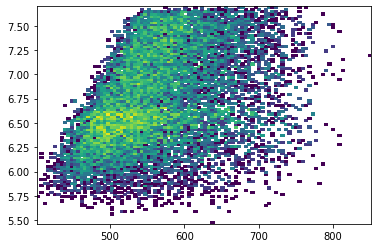

In [39]:
plt.hist2d(df_coinc['Xmax'].values,np.log10(df_coinc['MaxNum'].values),bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [40]:
df_coinc.keys()

Index(['Unnamed: 0', 'mass', 'energy', 'zenith', 'S125', 'energy_loss',
       'he_stoch', 'he_stoch2', 'Xmax', 'Xo', 'A', 'm_125', 'm_r', 'm_s',
       'm_s2', 'm_o', 'm_chi2', 'fit_status_m', 's_mean', 's_std', 'charge',
       'N', 'ghRedChiSqr', 'firstint', 'max_check', 'new_xmax', 'new_xo',
       'new_lambda', 'fit_status', 'new_chi2', 'difference', 'MaxNum',
       'log_energy', 'cos_zenith', 'log_energy_loss', 'log_xo', 'log_m_r',
       'log_charge', 'log_s_std', 'log_s_mean'],
      dtype='object')

In [41]:
from sklearn.model_selection import train_test_split

In [42]:
validation = df_coinc.sample(frac=0.1,random_state=42)

In [43]:
'm_r','m_s','m_125','m_o','m_s2'

('m_r', 'm_s', 'm_125', 'm_o', 'm_s2')

In [44]:
validation_y =  validation[['log_energy','Xmax','mass','log_charge']].values
validation_X = validation[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_s2','m_o','m_s','m_125']].values

In [45]:
df_coinc = df_coinc.drop(validation.index)

In [46]:
y = df_coinc[['log_energy','Xmax','mass','log_charge']].values
X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_s2','m_o','m_s','m_125']].values
#X = df_coinc[['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2']].values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
weight = []
for i in y_train:
    if i[0] == 1:
        weight.append(1)
    elif i[0] == 2:
        weight.append(len(proton)/len(helium))
    elif i[0] == 3:
        weight.append(len(proton)/len(oxygen))
    else:
        weight.append(len(proton)/len(iron))
weight=np.array(weight)

In [49]:
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

In [50]:
#tree = BaggingRegressor(DecisionTreeRegressor(splitter='best',max_features='log2',random_state=42),n_estimators=400,bootstrap=True,random_state=42)
#tree2 = BaggingRegressor(DecisionTreeRegressor(splitter='random',max_features='log2',random_state=42),n_estimators=400,bootstrap=True,random_state=42)

In [51]:
tree = MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.1,max_features='log2'))
tree2 =BaggingRegressor(DecisionTreeRegressor(splitter='best',max_features='log2',random_state=42),n_estimators=400,bootstrap=True,random_state=42)

In [52]:
tree.fit(X_train,y_train[:,1:3],sample_weight=y_train[:,-1])
tree2.fit(X_train[:,0:9],y_train[:,0],sample_weight=y_train[:,-1])

BaggingRegressor(base_estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='log2',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      presort='deprecated',
                                                      random_state=42,
                                                      splitter='best'),
                 bootstrap=T

In [53]:
predictions = tree.predict(X_test)
predictions2 = tree2.predict(X_test[:,0:9])

In [54]:
#energy_predictions = np.array(list(zip(*predictions))[0])
energy_predictions=predictions2
energy = np.array(list(zip(*y_test))[0])
xmax = np.array(list(zip(*y_test))[1])
#x_o = np.array(list(zip(*y_test))[0])
xmax_predictions = np.array(list(zip(*predictions))[0])
mass = np.array(list(zip(*y_test))[-2])

In [55]:
value = [(i-j) for i,j in zip(xmax_predictions,xmax)]

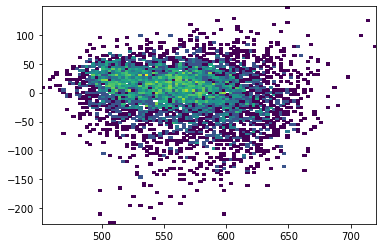

In [56]:
plt.hist2d(xmax_predictions,value,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [57]:
np.corrcoef(list(zip(*X_test)),value)

array([[ 1.        ,  0.09182389,  0.03394828,  0.36001136,  0.09360376,
         0.470481  , -0.08810323,  0.17654985, -0.01661362,  0.51398581,
         0.03816849],
       [ 0.09182389,  1.        ,  0.78506783,  0.40508665,  0.07702075,
        -0.03271858, -0.31229943,  0.74412905, -0.08862337,  0.10313286,
        -0.0784664 ],
       [ 0.03394828,  0.78506783,  1.        ,  0.4226738 ,  0.11337029,
        -0.0567498 , -0.26151075,  0.56928483, -0.07043065,  0.04643364,
         0.05305885],
       [ 0.36001136,  0.40508665,  0.4226738 ,  1.        ,  0.29738682,
         0.14663881, -0.11907656,  0.3043639 , -0.04112648,  0.20597681,
         0.00674747],
       [ 0.09360376,  0.07702075,  0.11337029,  0.29738682,  1.        ,
         0.05209073, -0.00650211,  0.04025754, -0.00375318,  0.06070992,
        -0.00127679],
       [ 0.470481  , -0.03271858, -0.0567498 ,  0.14663881,  0.05209073,
         1.        , -0.01046249, -0.21659461,  0.02543135,  0.98380494,
        -0.019

In [58]:
values = list(zip(xmax_predictions,list(zip(*X_test))[3]))

In [59]:
line_model = LinearRegression()

In [60]:
line_model.fit(xmax_predictions.reshape(-1,1),value)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
line_model.coef_

array([-0.18369404])

In [62]:
line_model.intercept_

103.26469667703084

In [63]:
validation_xmax = np.array(list(zip(*validation_y)))[1]

In [64]:
check_predictions = tree.predict(validation_X)

In [65]:
bias = line_model.predict(xmax_predictions.reshape(-1,1))
bias2 = line_model.predict(validation_xmax.reshape(-1,1))

In [66]:
xmax_predictions = np.array([(i-j) for i,j in zip(xmax_predictions,bias)])
xmax_predictions2 = np.array([(i-j) for i,j in zip(list(zip(*check_predictions))[0],bias2)])

In [67]:
#xmax_predictions2 = list(zip(*check_predictions))[0]

In [68]:
import matplotlib

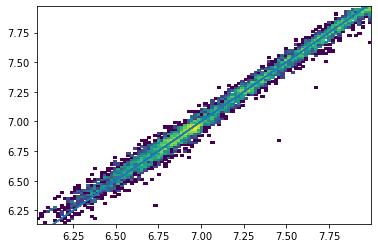

In [69]:
plt.hist2d(energy,energy_predictions,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(energy,energy)
plt.show()

In [70]:
np.corrcoef(energy,energy_predictions)[0][1]

0.9938200786442668

In [71]:
print(np.mean([(i-j)**2 for i,j in zip(energy,energy_predictions)]))

0.002604913813460857


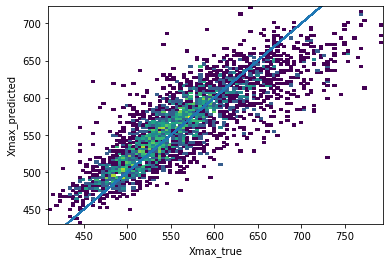

In [72]:
plt.hist2d(validation_xmax,xmax_predictions2,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(validation_xmax,validation_xmax)
plt.xlabel('Xmax_true')
plt.ylabel('Xmax_predicted')
plt.savefig('decision_True_vs_predicted_after.png')
#plt.show()

In [92]:
mean_xmax,std_xmax,bins_xmax,median_xmax = binning(xmax,xmax_predictions,15,plot=False)

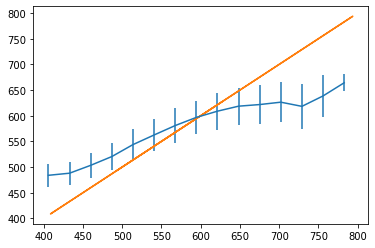

In [93]:
plt.errorbar(bins_xmax,mean_xmax,yerr=std_xmax)
plt.plot(validation_xmax,validation_xmax)
plt.savefig('before.png')

In [91]:
mse = np.mean([(i-j)**2 for i,j in zip(xmax,xmax_predictions)])
print(mse)

1835.270524270111


In [76]:
np.corrcoef(validation_xmax,xmax_predictions2)[0][1]

0.8409972957316321

In [77]:
check = (energy_predictions>=0)

In [78]:
predictions = predictions[check]

In [79]:
mass = mass[check]

In [80]:
energy = np.array(energy)

In [81]:
iron_energy = predictions2[mass==4]
proton_energy = predictions2[mass==1]
helium_energy = predictions2[mass==2]
oxygen_energy= predictions2[mass==3]

In [82]:
iron_xmax = np.array(xmax_predictions)[mass==4]
proton_xmax = np.array(xmax_predictions)[mass==1]
helium_xmax = np.array(xmax_predictions)[mass==2]
oxygen_xmax = np.array(xmax_predictions)[mass==3]

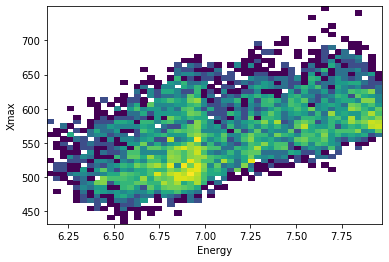

In [83]:
Xmax_predicted = xmax_predictions
check = (Xmax_predicted>400)&(Xmax_predicted<800)&(predictions2>6)
plt.hist2d(predictions2[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

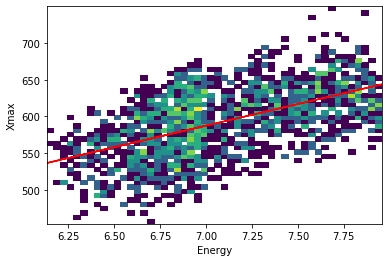

58.71554068875373 176.52361191285755


In [84]:
Xmax_predicted = proton_xmax
check_proton = (Xmax_predicted>400)&(Xmax_predicted<800)
fit_proton = curve_fit(line_function,proton_energy[check_proton],Xmax_predicted[check_proton])
output_xmax_proton = line_function(proton_energy[check_proton],fit_proton[0][0],fit_proton[0][1])

plt.hist2d(proton_energy[check_proton],Xmax_predicted[check_proton],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(proton_energy[check_proton],output_xmax_proton,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_proton[0][0],fit_proton[0][1])

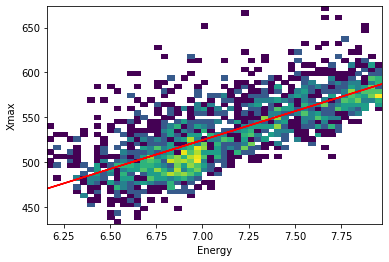

64.26024411678662 74.92465436328628


In [85]:
Xmax_predicted = iron_xmax
check_iron = (Xmax_predicted>400)&(Xmax_predicted<800)
fit_iron = curve_fit(line_function,iron_energy[check_iron],Xmax_predicted[check_iron])
output_xmax_iron = line_function(iron_energy[check_iron],fit_iron[0][0],fit_iron[0][1])

plt.hist2d(iron_energy[check_iron],Xmax_predicted[check_iron],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(iron_energy[check_iron],output_xmax_iron,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit_iron[0][0],fit_iron[0][1])

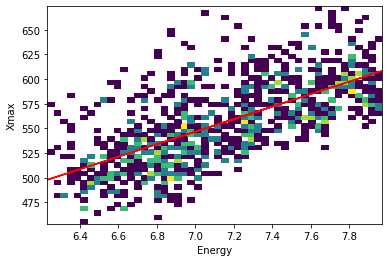

63.43269168393031 102.65623629106211


In [86]:
Xmax_predicted = oxygen_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<800)
fit = curve_fit(line_function,oxygen_energy[check],Xmax_predicted[check])
output_xmax = line_function(oxygen_energy[check],fit[0][0],fit[0][1])

plt.hist2d(oxygen_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(oxygen_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

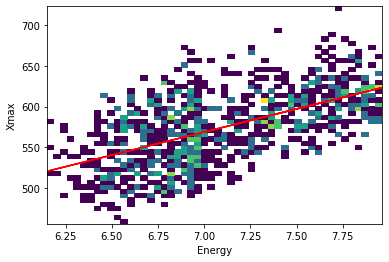

56.9108148138585 170.25789265916282


In [87]:
Xmax_predicted = helium_xmax
check = (Xmax_predicted>400)&(Xmax_predicted<800)
fit = curve_fit(line_function,helium_energy[check],Xmax_predicted[check])
output_xmax = line_function(helium_energy[check],fit[0][0],fit[0][1])

plt.hist2d(helium_energy[check],Xmax_predicted[check],bins=50,norm=matplotlib.colors.LogNorm())
plt.plot(helium_energy[check],output_xmax,color='red')
plt.xlabel('Energy')
plt.ylabel('Xmax')
#plt.savefig('Xmax_energy_after.png')
plt.show()

print(fit[0][0],fit[0][1])

In [88]:
mean_proton,std_proton,bins_proton,median_proton = binning(proton_energy,proton_xmax,30)
mean_iron,std_iron,bins_iron,median_iron = binning(iron_energy,iron_xmax,30)
mean_oxygen,std_oxygen,bins_oxygen,median_oxygen = binning(oxygen_energy,oxygen_xmax,30)
mean_helium,std_helium,bins_helium,median_helium = binning(helium_energy,helium_xmax,30)

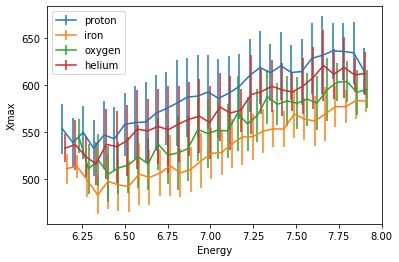

In [89]:
plt.errorbar(bins_proton,mean_proton,yerr=std_proton,label='proton')
plt.errorbar(bins_iron,mean_iron,yerr=std_iron,label='iron')
plt.errorbar(bins_oxygen,mean_oxygen,yerr=std_oxygen,label='oxygen')
plt.errorbar(bins_helium,mean_helium,yerr=std_helium,label='helium')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('Decision_All_species_energy_xmax_no_in_ice.png')
#plt.show()

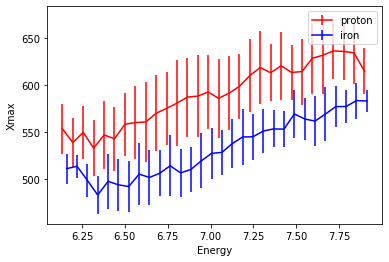

In [90]:
plt.errorbar(bins_proton,mean_proton,yerr=std_proton,color='r',label='proton')
plt.errorbar(bins_iron,mean_iron,yerr=std_iron,color='b',label='iron')
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Xmax')
plt.savefig('decision_Proton_vs_Iron.png')
plt.show()